# volality prediction

データの情報に関して
- parquet形式でbookとtradeが存在している

コンペ自体の中身は、各銘柄（id_stock)で、特定の時間区切り(time_id)の10分間の時系列データ(seconds_in_bucket)があり、その時間区切りでの価格変動の大小についてボラリティとして評価している。

## parquetとは

列指向のデータでCSVが行指向であるならば、性質が異なるデータファイルとなる。データ分析のために最適化されたデータベースで、大規模な集計処理を高速に行うことが出来る。
行で読み解くとすべての列を取得しながら読み込むため特定の列だけを用いたい場合にデータ量が膨大になる。列で読み込むことで早くなるらしい。

## Optiver社

金融商品の正確な価格設定により、効率的で透明性のある健全な市場に貢献することが中心的な活動である。オプション、ＥＦＴ，債券、世界中の取引所の外貨を含む幅広い商品に及ぶ。

最終投資家のために競争力のある価格を継続的に生み出すために、理論的ボラリティモデルを構築し依存している。つまり、マーケットメイクは実際にはデータに基づいており、市場データの収集量は日々増加している。データサイエンティストには新鮮な視点と革新的なアプローチを求めている。

## 日本語の資料を見る

目的はビックデータから10分間のボラリティを予測するモデルを設計する。直前(10min)のbookデータは与えられている。

ボラリティとは、価格変動のことであり、一年間の価格の対数値の標準偏差を表す。

## データに関して

データ
テストセットの最初の数行のみをダウンロードできるコード競争です。

→　提出ファイルは三行だけですが、実際はたくさんデータがあるようです（テストデータの最初の三行だけを読み込んでいる。）

以下はgoogle翻訳べた張り

### book_ [train / test] .parquet

区切られた寄木細工のファイルstock_id。市場に投入された最も競争力のある売買注文に関するオーダーブックデータを提供します。本の上位2つのレベルが共有されます。本の第1レベルは価格面でより競争力があり、第2レベルよりも実行が優先されます。

- stock_id -株式のIDコード。すべてのストックIDがすべてのタイムバケットに存在するわけではありません。Parquetは、ロード時にこの列をカテゴリデータ型に強制します。あなたはそれをint8に変換したいかもしれません。
- time_id -タイムバケットのIDコード。時間IDは必ずしも連続している必要はありませんが、すべての在庫で一貫しています。
- seconds_in_bucket -バケットの開始からの秒数。常に0から始まります。
- bid_price[1/2] -最も競争力のある購入レベルの正規化された価格。
- ask_price[1/2] -最も競争力のある販売レベルの正規化された価格。
- bid_size[1/2] -最も競争力のある購入レベルでの株式数。
- ask_size[1/2] -最も競争力のある/ 2番目に競争力のある販売レベルの株式数。

### trade_[train/test].parquet

区切られた寄木細工のファイルstock_id。実際に実行された取引に関するデータが含まれています。通常、市場では、実際の取引よりも受動的な売買意図の更新（本の更新）が多いため、このファイルは注文書よりもまばらであると予想される場合があります。

- stock_id - 同上。
- time_id - 同上。
- seconds_in_bucket- 同上。トレードデータとブックデータは同じ時間枠から取得され、トレードデータは一般にまばらであるため、このフィールドは必ずしも0から始まるとは限らないことに注意してください。
- price -1秒間に発生する実行済みトランザクションの平均価格。価格は正規化されており、平均は各取引で取引された株式数によって加重されています。
- size -取引された株式の総数。
- order_count -発生している固有の取引注文の数。

time_idは異なるデータセット間のブリッジとして機能するためにあるもので、それ以外に情報は含まれていない。したがって、時系列データではないことに注意する。

bookとtradeに関しては次のURLを参考にしておく。

https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data



In [10]:
import pandas as pd
import numpy as np
import pandas_profiling
import lightgbm as lgb
import optuna
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# トレーニングセットの正解値?
train = pd.read_csv("optiver-realized-volatility-prediction/train.csv")

In [4]:
train.head(5)

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [5]:
# テスト
test = pd.read_csv("optiver-realized-volatility-prediction/test.csv")

In [6]:
train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


ちょっとよくわからないので、チュートリアルに沿って内容を理解していく。特にparquetを知ることもひとつの要素かな。

In [7]:
# id=0で様子を見る
book_trainparquet = pd.read_parquet("optiver-realized-volatility-prediction/book_train.parquet/stock_id=0")
book_testparquet = pd.read_parquet("optiver-realized-volatility-prediction/book_test.parquet/stock_id=0")

In [8]:
book_trainparquet

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28


In [9]:
book_testparquet

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,4,0,1.000049,1.000590,0.999656,1.000639,91,100,100,24
1,4,1,1.000049,1.000590,0.999656,1.000639,91,100,100,20
2,4,5,1.000049,1.000639,0.999656,1.000885,290,20,101,15


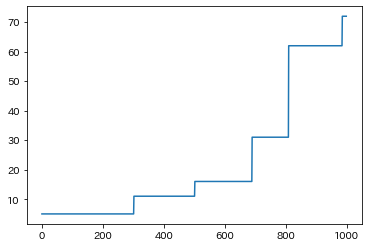

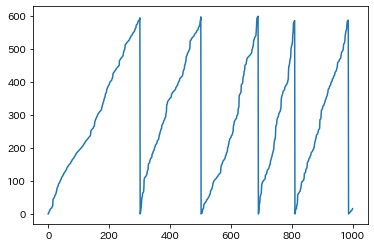

In [12]:
# 1000行までを可視化してみる
plt.plot(np.array(book_trainparquet['time_id'][:1000]))
plt.show()
plt.plot( np.array( book_trainparquet['seconds_in_bucket'][:1000] ) )
plt.show()

C:\Users\imoya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


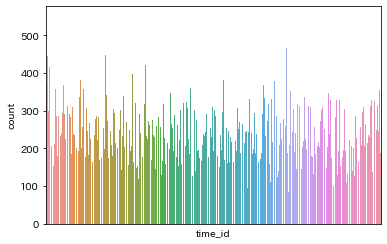

In [13]:
# barplotでtime_idの個数を確認する
sns.countplot(book_trainparquet["time_id"])
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.show()

In [ ]:
# 次にtime_id=5の銘柄の推移を確認する
